In [1]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import numpy as np
from datetime import timedelta
from scipy.signal import argrelextrema

class GoldChartGenerator:
    def __init__(self, symbol="GC=F"):
        self.symbol = symbol
        self.df = None
    
    def fetch_data(self, period="60d", interval="5m"):
        """データの取得期間と足を指定してデータの取得"""
        df = yf.download(
            self.symbol,
            interval=interval,
            period=period,
            progress=False
        )

        # MultiIndexの解除
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)

        for col in ["Open", "High", "Low", "Close", "Volume"]:
            df[col] = pd.to_numeric(df[col], errors="coerce")
        
        df.dropna(inplace=True)

        # タイムゾーン処理
        if df.index.tz is None:
            df.index = df.index.tz_localize('UTC')
        df.index = df.index.tz_convert('Asia/Tokyo')
        df.index.name = "Datetime"

        # 200SMA計算
        df['MA200'] = df['Close'].rolling(window=200).mean()
        self.df = df
        return self.df
    
    def _get_levels(self, df, window=30):
        """局所的な高値を見つける内部関数"""
        levels = []

        highs = df['High'].values
        peaks = argrelextrema(highs, np.greater, order=window)[0]
        for p in peaks:
            levels.append((df.iloc[p]['High'], "High"))

        lows = df['Low'].values
        troughs = argrelextrema(lows, np.less, order=window)[0]
        for t in troughs:
            levels.append((df.iloc[t]['Low'], "Low"))

        return levels
    
    def generate_chart(self, display_hours=12, y_range=30, figsize=(12, 10), save_path=None):
        """チャートの生成と表示"""
        if self.df is None:
            print("先に fetch_data を実行してください")
            return
        
        # --- 表示用データ ---
        plot_start = self.df.index[-1] - timedelta(hours=display_hours)
        df_plot = self.df[self.df.index >= plot_start].copy()

        if df_plot.empty:
            print("表示期間内のデータがありません")
            return
        
        current_price = self.df['Close'].iloc[-1]
        ma200_plot = self.df.loc[df_plot.index, 'MA200']

        # ---サポレジ検出と整理 ---
        raw_levels = self._get_levels(self.df)
        raw_levels.sort(key=lambda x: x[0])

        levels = []
        if raw_levels:
            current_group = [raw_levels[0][0]]
            for i in range(1, len(raw_levels)):
                price = raw_levels[i][0]
                if price - current_group[-1] < 1.0:
                    current_group.append(price)
                else:
                    levels.append(np.mean(current_group))
                    current_group = [price]
            levels.append(np.mean(current_group))

        
        # --- 線の設定 ---
        hlines_levels, hlines_colors, hlines_styles, hlines_widths = [], [], [], []

        # 長期の壁
        long_high, long_low = self.df['High'].max(), self.df['Low'].min()
        for val, style in [(long_high, '-'), (long_low, ':')]:
            hlines_levels.append(val)
            hlines_colors.append('red')
            hlines_styles.append(style)
            hlines_widths.append(2.5)
        
        # サポレジ
        nearby_levels = [lvl for lvl in levels if abs(lvl - current_price) < y_range]
        colors = ['blue', 'purple', 'green', 'teal', 'magenta']
    
        for i, level in enumerate(nearby_levels):
            hlines_levels.append(level)
            hlines_colors.append(colors[i % len(colors)])
            hlines_styles.append('--' if level > current_price else ':')
            hlines_widths.append(2.0)
        
        # --- ズーム設定 ---
        view_high, view_low = df_plot['High'].max(), df_plot['Low'].min()
        price_diff = view_high - view_low
        padding = max(5.0, price_diff * 0.3)

        y_limit_bottom = view_low - padding
        y_limit_top = view_high + padding

        # --- プロット実行 ---
        ap = [mpf.make_addplot(ma200_plot, color = 'red', width=2)]

        plot_args = {
            "type":"candle",
            "volume":True,
            "style":"yahoo",
            "title":"Gold Multi-Level Support & Resistance",
            "addplot":ap,
            "hlines":dict(
                hlines=hlines_levels,
                colors=hlines_colors,
                linestyle=hlines_styles,
                linewidths=hlines_widths,
                alpha=0.7
            ),
            "ylim":(y_limit_bottom, y_limit_top),
            "datetime_format":"%H:%M",
            "figsize":figsize,
            "tight_layout":True
        }

        # save_pathの引数に中身が入っていれば
        if save_path:
            plot_args["savefig"] = save_path
        
        mpf.plot(df_plot, **plot_args)

        print(f"現在価格: {current_price:.2f}")
        print(f"表示範囲: {y_limit_bottom:.2f} 〜 {y_limit_top:.2f}")
        if save_path:
            print(f"画像を保存しました: {save_path}")


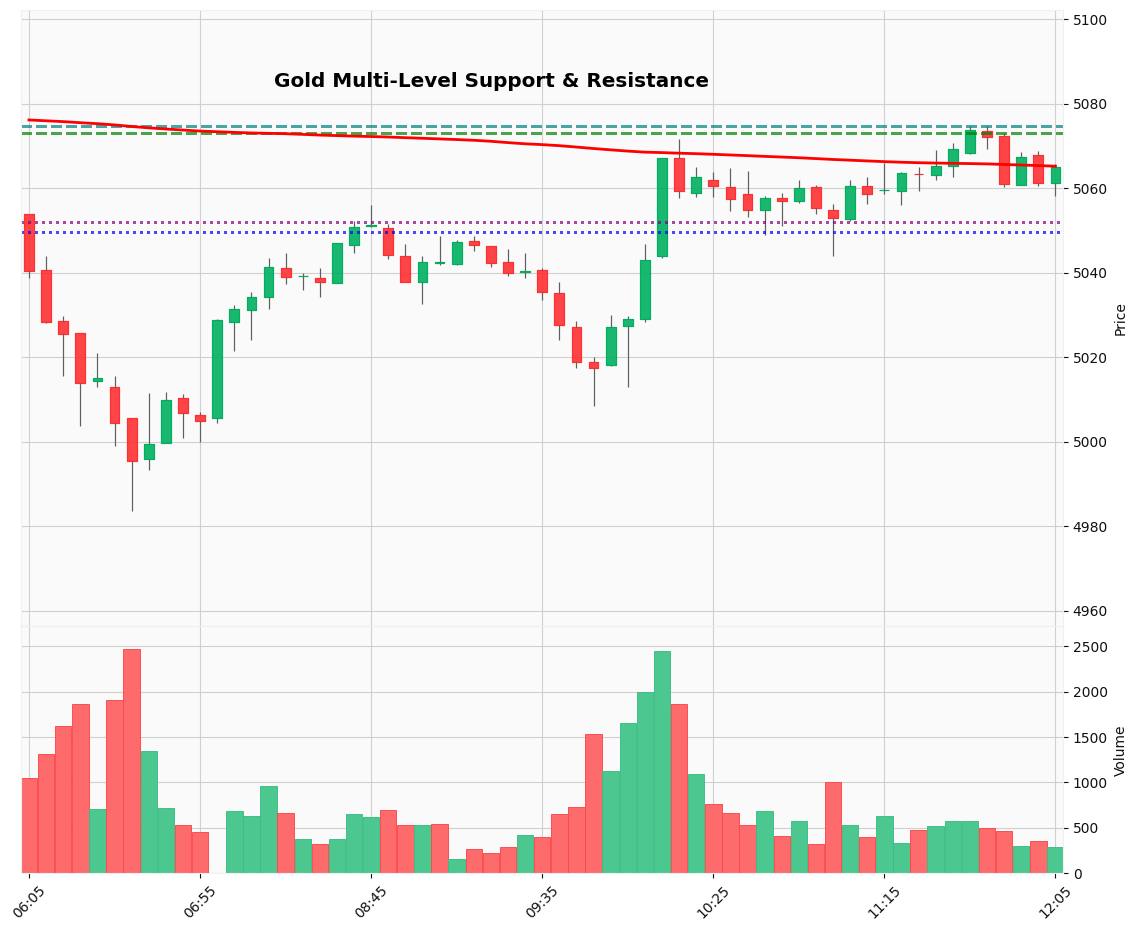

現在価格: 5064.90
表示範囲: 4956.24 〜 5102.16


In [2]:
# --- 実行例 ---
if __name__ == "__main__":
    generator = GoldChartGenerator()
    
    # データを取得
    generator.fetch_data(period="5d", interval="5m")
    
    # チャートを表示（保存しない場合）
    generator.generate_chart(display_hours=6, y_range=20)

    # チャートを保存する場合（ファイル名を指定）
    # generator.generate_chart(display_hours=6, save_path="gold_chart.png")